# Simplified Direct Sampling aka Direct Sampling Best Candidate (DSBC)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ot

from geone import img
from geone import imgplot
from geone import deesseinterface

import copy

In [2]:
%load_ext autoreload
%autoreload 1
%aimport ensemble, simulator, scoring, antarctic, mpstool

## Test 2. Continuous with pyramides.

In [3]:
bedmap = np.fromfile('bedmap2/bedmap2_bin/bedmap2_bed.flt', dtype='float32')
bedmap = bedmap.reshape((6667, 6667))

In [4]:
uncertain = np.fromfile('bedmap2/bedmap2_bin/bedmap2_grounded_bed_uncertainty.flt', dtype='float32')
uncertain = uncertain.reshape((6667, 6667))

In [5]:
bedmap[uncertain>500] = -9999
bedmap[bedmap==-9999] = np.nan
ti = img.Img(nx=bedmap.shape[1], ny=bedmap.shape[0], nz=1, nv=1, sx=1, sy=1, sz=1, ox=0, val=np.flipud(bedmap)[np.newaxis, np.newaxis])

In [6]:
#plt.figure(figsize=(15,15))
#imgplot.drawImage2D(ti, cmap='magma')

In [7]:
simulator = antarctic.AntarcticDS('test/test', nneighboringNode=20, distanceThreshold=0.005, maxScanFraction=0.01,
                                 ox=4000, oy=2000, nx=200, ny=200)

In [8]:
locations = [(1100, 4200),
             (3700, 2000),
             (1700, 3500),
             (3500, 5200),
             (4900, 3900),
             (4200, 3500),
             (2500, 2700),
             (5000, 2700),
             (4700, 1000),
             (4700, 2000),
             ]

In [9]:
#ti_dr = copy.deepcopy(ti)
#for x, y in locations:
#    print(x, y)
#    simulator = antarctic.AntarcticDS(f'test/test-{x}-{y}',
#                                      nneighboringNode=20,
#                                      distanceThreshold=0.005,
#                                      maxScanFraction=0.01,
#                                      ox=x, oy=y,
#                                      nx=200, ny=200)
#    ti_dr = simulator.cut_ti(ti_dr)
#plt.figure(figsize=(15,15))
#imgplot.drawImage2D(ti_dr, cmap='magma')
    #plt.figure()
    #imgplot.drawImage2D(simulator.sim_grid(ti), cmap='magma')
    #plt.figure()
    #imgplot.drawImage2D(simulator.im_ref(ti), cmap='magma')

In [10]:
def ds_simulation_parameters(ox, oy):
    parameter_sets = [ [n, i] for n in [8, 16, 32, 64] for i in [0.001, 0.002, 0.005, 0.01]]

    df = pd.DataFrame(parameter_sets, columns = ['nneighboringNode', 'distanceThreshold'])
    df['maxScanFraction'] = 0.01
    df['ox'] = ox
    df['oy'] = oy
    return df

In [11]:
def generate_df(locations, parameter_function):
    return pd.concat([parameter_function(ox, oy)
           for ox, oy in locations],
          ignore_index=True)

In [12]:
df_ds = generate_df(locations, ds_simulation_parameters)

In [13]:
def load_ensembles(row, simulator_class):
    ox = int(row['ox'])
    oy = int(row['oy'])
    simulator_obj = simulator_class(
                 nneighboringNode=row['nneighboringNode'],
                 distanceThreshold=row['distanceThreshold'],
                 maxScanFraction=row['maxScanFraction'],
                 root_dir=f'case2/ds-{ox}-{oy}/',
                 ox=ox,
                 oy=oy)
    
    ensemble, timing = simulator_obj.get_ensemble(ti,
                                                  ensemble_size=40,
                                                  nthreads=40,
                                                  seed=444,
                                                  overwrite=True,
                                                  dtype='float')
    row['time'] = timing
    row['ensemble_size'] = ensemble.size
    
    return row

In [14]:
df_ds = df_ds.apply(lambda row: load_ensembles(row, antarctic.AntarcticDS), axis=1)
df_ds

,nneighboringNode,distanceThreshold,maxScanFraction,ox,oy,time,ensemble_size
0,8.0,0.001,0.01,1100.0,4200.0,646.061953,40.0
1,8.0,0.002,0.01,1100.0,4200.0,305.607407,40.0
2,8.0,0.005,0.01,1100.0,4200.0,158.568862,40.0
3,8.0,0.010,0.01,1100.0,4200.0,93.833860,40.0
4,16.0,0.001,0.01,1100.0,4200.0,1423.687609,40.0
...,...,...,...,...,...,...,...
155,32.0,0.010,0.01,4700.0,2000.0,223.741283,40.0
156,64.0,0.001,0.01,4700.0,2000.0,3879.927086,40.0
157,64.0,0.002,0.01,4700.0,2000.0,1822.478574,40.0
158,64.0,0.005,0.01,4700.0,2000.0,1049.281418,40.0


In [15]:
def dsbc_simulation_parameters(ox, oy):
    parameter_sets = [ [n, f] for n in [16, 32, 64] 
                      for f in [2e-3, 1e-3, 1e-4, 1e-5]]

    df = pd.DataFrame(parameter_sets, columns=['nneighboringNode','maxScanFraction'])
    df['distanceThreshold'] = 0
    df['ox'] = ox
    df['oy'] = oy
    return df

In [16]:
df_dsbc = generate_df(locations, dsbc_simulation_parameters)

In [17]:
df_dsbc = df_dsbc.apply(lambda row:
                            load_ensembles(row,
                                antarctic.AntarcticDSBC),
                        axis=1)
df_dsbc

,nneighboringNode,maxScanFraction,distanceThreshold,ox,oy,time,ensemble_size
0,16.0,0.00200,0.0,1100.0,4200.0,756.250556,40.0
1,16.0,0.00100,0.0,1100.0,4200.0,430.184379,40.0
2,16.0,0.00010,0.0,1100.0,4200.0,134.885196,40.0
3,16.0,0.00001,0.0,1100.0,4200.0,155.490508,40.0
4,32.0,0.00200,0.0,1100.0,4200.0,830.519947,40.0
...,...,...,...,...,...,...,...
115,32.0,0.00001,0.0,4700.0,2000.0,156.357464,40.0
116,64.0,0.00200,0.0,4700.0,2000.0,1007.217321,40.0
117,64.0,0.00100,0.0,4700.0,2000.0,563.019934,40.0
118,64.0,0.00010,0.0,4700.0,2000.0,155.385320,40.0


In [18]:
ensemble1  = ensemble.Ensemble.from_directory('case2/ds-3700-2000/ds-16.0-0.001-0.01/')

In [19]:
ensemble1.members[0]

array([[-383., -414., -423., ...,  368.,  359.,  455.],
       [-359., -363., -371., ...,  434.,  493.,  396.],
       [-318., -302., -306., ...,  501.,  444.,  527.],
       ...,
       [-309., -279., -246., ...,  552.,  650.,  670.],
       [-231., -180., -222., ...,  527.,  594.,  580.],
       [-293., -185., -240., ...,  519.,  540.,  580.]])

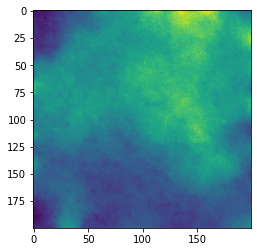

In [20]:
plt.imshow(ensemble1.members[1])

In [21]:
imm = ensemble1.members[1]

In [22]:
minn = np.min(ensemble1.members[1])

In [23]:
maxx = np.max(ensemble1.members[1])

In [24]:
tresholds = np.linspace(minn, maxx, 100)[0]

In [25]:
def apply_t(imm, t):
    im = copy.copy(imm)
    im[im < t] = 0
    im[im != 0] = 1
    return im

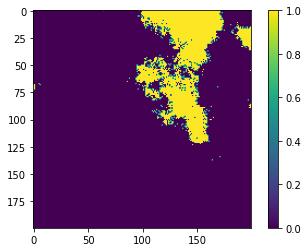

In [26]:
plt.imshow(apply_t(imm, 1000))
plt.colorbar()

In [48]:
import mpstool
comps = mpstool.connectivity.get_components(apply_t(imm, 1000), background=1)

In [49]:
values, counts = np.unique(comps, return_counts=True)
values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177])

In [40]:
G, thresholds = mpstool.connectivity.get_Gamma(ensemble1.members[1], 200)

In [41]:
Gc, thresholds = mpstool.connectivity.get_Gamma(ensemble1.members[1], 200, complementary=True)

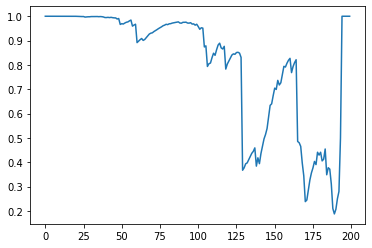

In [42]:
plt.plot(G)

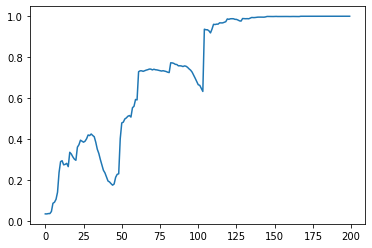

In [43]:
plt.plot(Gc)

In [48]:
np.unique(comps)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139])

In [51]:
values, counts = np.unique(comps, return_counts=True)
G = np.sum(counts[1:]**2) / np.sum(counts[1:])**2
G

0.8357332001859472

In [55]:
u = True

In [56]:
b = 0 if u == False else 1

In [57]:
b

1

In [50]:
values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139])